## Cancer Diagnosis Capstone Project Modeling

The purpose of this part of the project is to use different modeling methods in order to determine if there is a model that performs better than the Logistic Regression baseline model in predicting whether a breast cancer tumor is benign or malignant.  To recap, two datasets are being compared.  The first is the dataset with all of the original variables, with an exception of perimeter mean and area mean, because they are direct correlations to radius.  The second is the dataset with all of the highly correlated variables used.  This only leaves five variables, which are: <br>
radius mean<br>
texture mean<br>
smoothness mean<br>
area standard error<br>
concavity standard error

Both of these models will be used throughout.  The models that are going to be used are (with the different hyperparameters that will be compared using GridSearchCV):<br>
**K-Nearest Neighbors (KNN)** <br>
Number of Neighbors: Range from 1-10 <br>
P (Power parameter for the Minkowski metric): 1(Manhattan Distance), 2(Euclidean Distance)<br>
Weights: Uniform or distance

**Support Vector Classification** <br>
Kernels: Linear, rbf, poly <br>
Gammas: 0.1, 1, 10, 100 <br>
Cs: 0.1, 1, 10, 100

**XGBoost Classification** <br>
Learning rate (eta) : 0.01, 0.1, 1 <br>
Max depth: 2, 5, 10 <br>
Number of Estimators: 2, 5, 10 

After the best hyperparameters are found and each model is run, we will then test the performance of the model using an accuracy score, a confusion matrix, an roc curve, finding the area under the curve(AUC), and looking at the classification report.  These are the scores that will be compared to the baseline model.

The ideal targeted metrics are: <br>
1. Accuracy of at least 95% <br>
2. Less than 2.5% false negatives <br>
3. A recall of at least 95% <br>
4. AUC of at least 99%


#### Importing and examining the data

I will first import anything that I need, including the same split data that was used in the baseline model. 

In [1]:
#Import everything that I plan on using during this project
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

#Import models that I want to use
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import xgboost as xgb

#Import scoring methods for the models
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.model_selection import validation_curve
from sklearn.metrics import classification_report

#ignore warning messages to ensure clean outputs
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import all of the models that will be used, starting with the models of the full data
X_train_f = pd.read_csv('X_train_f.csv', index_col=0)
X_test_f = pd.read_csv('X_test_f.csv', index_col=0)
y_train_f = pd.read_csv('y_train_f.csv', index_col=0)
y_test_f = pd.read_csv('y_test_f.csv', index_col=0)

#Now the partial data
X_train_p = pd.read_csv('X_train_p.csv', index_col=0)
X_test_p = pd.read_csv('X_test_p.csv', index_col=0)
y_train_p = pd.read_csv('y_train_p.csv', index_col=0)
y_test_p = pd.read_csv('y_test_p.csv', index_col=0)

In [3]:
X_train_f.shape, X_test_f.shape

((455, 28), (114, 28))

In [4]:
y_train_f.shape, y_test_f.shape

((455, 1), (114, 1))

In [5]:
X_train_p.shape, X_test_p.shape

((455, 5), (114, 5))

In [6]:
y_train_p.shape, y_test_p.shape

((455, 1), (114, 1))

#### Modeling with KNN

The numbers look accurate, so now it's time to model.  For each model, I will first run GridSearchCV with a variety of hyperparameter options to see which is the best for the full variables and partial variables.  I will take those hyperparameters and run them with each model, and then score them.  These will be compared to the ideal target metrics to find the best model.

We will start with KNN. As a refresher, the hyperparameters used are:<br>
Number of Neighbors: Range from 1-10 <br>
P (Power parameter for the Minkowski metric): 1(Manhattan Distance), 2(Euclidean Distance)<br>
Weights: Uniform or distance

In [9]:
#First run KNN for the full model
knn = KNeighborsClassifier()
n_neighbors = list(range(1,10))
param_knn= {'n_neighbors':n_neighbors, 'p':[1,2],'weights':['uniform','distance']}

gs_knn_f = GridSearchCV(knn, param_knn, cv=5, n_jobs=-1)
gs_knn_f.fit(X_train_f, y_train_f)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'p': [1, 2], 'weights': ['uniform', 'distance']})

In [10]:
gs_knn_f.best_params_

{'n_neighbors': 6, 'p': 1, 'weights': 'distance'}

In [18]:
knn_f = KNeighborsClassifier(n_neighbors=6, p=1, weights='distance')
model_knn_f = knn_f.fit(X_train_f,y_train_f)
y_pred_knn_f = model_knn_f.predict(X_test_f)
accuracy_score_knn_f = accuracy_score(y_test_f, y_pred_knn_f)
accuracy_score_knn_f

0.956140350877193

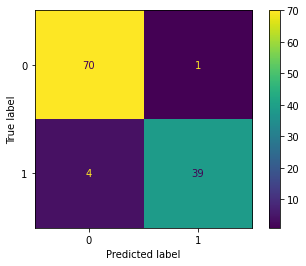

In [20]:
#Confussion matrix
knn_f_confusion_matrix = plot_confusion_matrix(model_knn_f, X_test_f, y_test_f)
knn_f_confusion_matrix

In [21]:
#Create a function for plotting ROC curve that can be used multiple times.
def plot_roc_curve(y_test, y_pred_prob, title, label=None):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=15)
    plt.ylabel('True Positive Rate (TPR)', fontsize=15)
    plt.title(title,fontsize=15)
    plt.show()

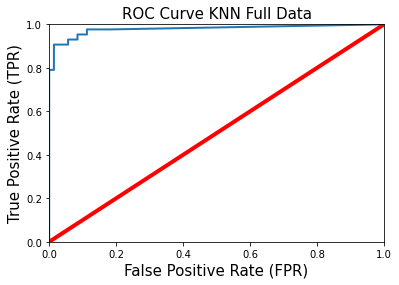

In [23]:
#plot the ROC curve
y_pred_prob_knn_f = knn_f.predict_proba(X_test_f)[:,1]
plot_roc_curve(y_test_f,y_pred_prob_knn_f,'ROC Curve KNN Full Data')

In [24]:
#Calculate the area under the curve.
roc_score_knn_f = roc_auc_score(y_test_f, y_pred_prob_knn_f)
print("AUC: ", roc_score_knn_f)

AUC:  0.9787094660989191


In [26]:
# Classification report, with a focus on recall
class_rep_knn_f = classification_report(y_test_f, y_pred_knn_f)
print(class_rep_knn_f)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97        71
           1       0.97      0.91      0.94        43

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



None of these metrics reached the ideal threshold and did not even reach the logistic regression base model numbers.  We will also run the tests with the partial dataset, starting with reruning the GridSearchCV in case the ideal parameters are different.

In [27]:
knn = KNeighborsClassifier()

gs_knn_p = GridSearchCV(knn, param_knn, cv=5, n_jobs=-1)
gs_knn_p.fit(X_train_p, y_train_p)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'p': [1, 2], 'weights': ['uniform', 'distance']})

In [28]:
gs_knn_p.best_params_

{'n_neighbors': 9, 'p': 1, 'weights': 'distance'}

In [29]:
knn_p = KNeighborsClassifier(n_neighbors=9, p=1, weights='distance')
model_knn_p = knn_p.fit(X_train_p,y_train_p)
y_pred_knn_p = model_knn_p.predict(X_test_p)
accuracy_score_knn_p = accuracy_score(y_test_p, y_pred_knn_p)
accuracy_score_knn_p

0.9122807017543859

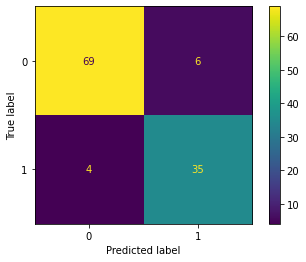

In [30]:
#Confussion matrix
knn_p_confusion_matrix = plot_confusion_matrix(model_knn_p, X_test_p, y_test_p)
knn_p_confusion_matrix

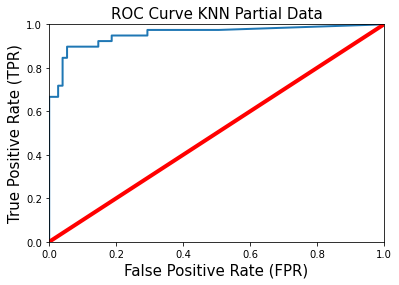

In [31]:
#plot the ROC curve
y_pred_prob_knn_p = knn_p.predict_proba(X_test_p)[:,1]
plot_roc_curve(y_test_p,y_pred_prob_knn_p,'ROC Curve KNN Partial Data')

In [32]:
#Calculate the area under the curve.
roc_score_knn_p = roc_auc_score(y_test_p, y_pred_prob_knn_p)
print("AUC: ", roc_score_knn_p)

AUC:  0.9553846153846153


In [33]:
# Classification report, with a focus on recall
class_rep_knn_p = classification_report(y_test_p, y_pred_knn_p)
print(class_rep_knn_p)

              precision    recall  f1-score   support

           0       0.95      0.92      0.93        75
           1       0.85      0.90      0.88        39

    accuracy                           0.91       114
   macro avg       0.90      0.91      0.90       114
weighted avg       0.91      0.91      0.91       114



These numbers are even worse.  We will visualize the numbers later, but none of the numbers looked to be as good as the baseline model.  We will run the SVC modeling.

#### Modeling with SVC

Now to model with SVC.  Both partial and full data will be analyzed, and GridSearchCV will be run to find the optimal hyperparameters.  As a refresher, the hyperparameters used are:<br>
Kernels: Linear, rbf, poly <br>
Gammas: 0.1, 1, 10, 100 <br>
Cs: 0.1, 1, 10, 100

In [ ]:
#Gridsearch with full model
svc = svm.SVC()
param_svc = {'kernel':['linear','rbf','poly'],'gamma':[0.1,1,10,100],'C':[0.1,1,10,100]}

gs_svc_f = GridSearchCV(svc, param_svc, cv=5, n_jobs=-1)
gs_svc_f.fit(X_train_f, y_train_f)